In [2]:
!pip install wandb

  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/ed/d7/8927aef63869d5d379adb63dc97f9cbc53830fdf85457b84a156fabcb231/wandb-0.15.8-py3-none-any.whl.metadata
  Obtaining dependency information for GitPython!=3.1.29,>=1.0.0 from https://files.pythonhosted.org/packages/67/50/742c2fb60989b76ccf7302c7b1d9e26505d7054c24f08cc7ec187faaaea7/GitPython-3.1.32-py3-none-any.whl.metadata
  Obtaining dependency information for sentry-sdk>=1.0.0 from https://files.pythonhosted.org/packages/86/bb/ecb87fd214d5bbade07edf2ecdd829cf346e5b552689d6228112c6517286/sentry_sdk-1.29.2-py2.py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for protobuf!=4.21.0,<5,>=3.19.0 from https://files.pythonhosted.org/packages/14/ff/10f746c03212fe48576b2c0f5ada73c3400b6d90f769728c4f07656d8b27/protobuf-4.24.2-cp310-abi3-win_amd64.whl.metadata
  Using cached gitdb-4.0.10-py3-non

# LLM Evaluation and Tracing with W&B

<!--- @wandbcode{dlai_04} -->

## 1. Using Tables for Evaluation

In this section, we will call OpenAI LLM to generate names of our game assets. We will use W&B Tables to evaluate the generations. 

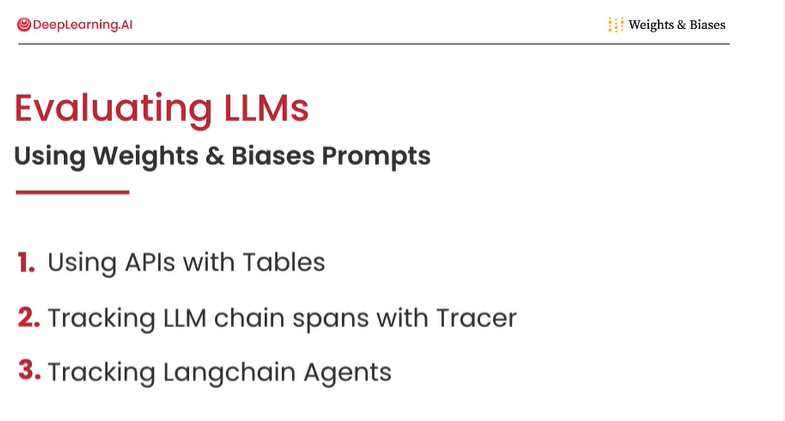


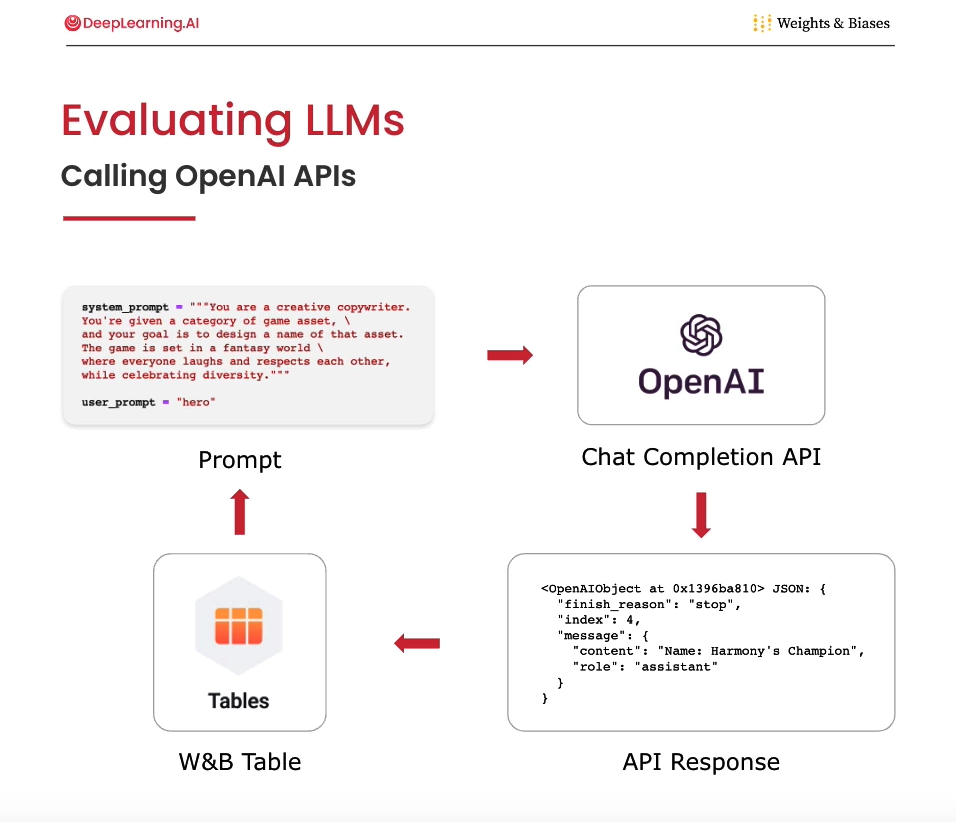

In [3]:
import os
import random
import time
import datetime

import openai

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential, # for exponential backoff
)  
import wandb
from wandb.sdk.data_types.trace_tree import Trace

In [4]:
# get openai API key
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
PROJECT = "dlai_llm"
MODEL_NAME = "gpt-3.5-turbo"

In [ ]:
wandb.login(anonymous="allow")

In [ ]:
run = wandb.init(project=PROJECT, job_type="generation")

### Simple generations
Let's start by generating names for our game assets using OpenAI `ChatCompletion`, and saving the resulting generations in W&B Tables. 

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

In [ ]:
def generate_and_print(system_prompt, user_prompt, table, n=5):
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    start_time = time.time()
    responses = completion_with_backoff(
        model=MODEL_NAME,
        messages=messages,
        n = n,
        )
    elapsed_time = time.time() - start_time
    for response in responses.choices:
        generation = response.message.content
        print(generation)
    table.add_data(system_prompt,
                user_prompt,
                [response.message.content for response in responses.choices],
                elapsed_time,
                datetime.datetime.fromtimestamp(responses.created),
                responses.model,
                responses.usage.prompt_tokens,
                responses.usage.completion_tokens,
                responses.usage.total_tokens
                )

In [ ]:
system_prompt = """You are a creative copywriter.
You're given a category of game asset, \
and your goal is to design a name of that asset.
The game is set in a fantasy world \
where everyone laughs and respects each other, 
while celebrating diversity."""

In [ ]:
# Define W&B Table to store generations
columns = ["system_prompt", "user_prompt", "generations", "elapsed_time", "timestamp",\
            "model", "prompt_tokens", "completion_tokens", "total_tokens"]
table = wandb.Table(columns=columns)

In [ ]:
user_prompt = "hero"
generate_and_print(system_prompt, user_prompt, table)

In [ ]:
user_prompt = "jewel"
generate_and_print(system_prompt, user_prompt, table)

In [ ]:
wandb.log({"simple_generations": table})
run.finish()

## 2. Using Tracer to log more complex chains

How can we get more creative outputs? Let's design an LLM chain that will first randomly pick a fantasy world, and then generate character names. We will demonstrate how to use Tracer in such scenario. We will log the inputs and outputs, start and end times, whether the OpenAI call was successful, the token usage, and additional metadata.

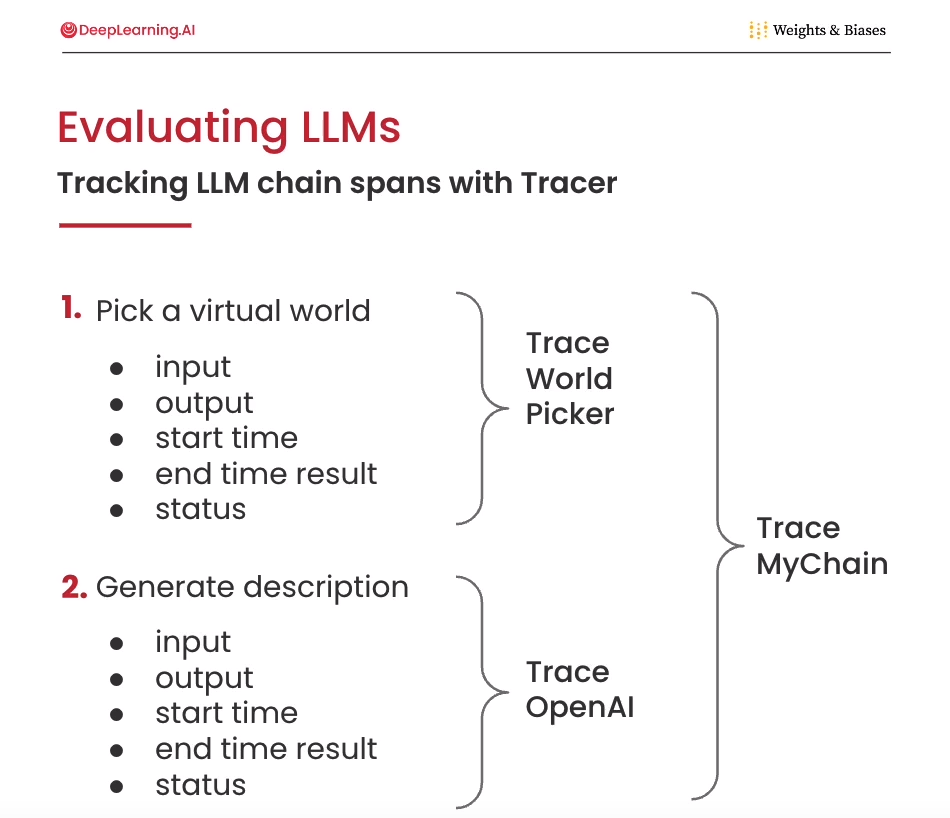

In [5]:
worlds = [
    "a mystic medieval island inhabited by intelligent and funny frogs",
    "a modern castle sitting on top of a volcano in a faraway galaxy",
    "a digital world inhabited by friendly machine learning engineers"
]

In [6]:
# define your config
model_name = "gpt-3.5-turbo"
temperature = 0.7
system_message = """You are a creative copywriter. 
You're given a category of game asset and a fantasy world.
Your goal is to design a name of that asset.
Provide the resulting name only, no additional description.
Single name, max 3 words output, remember!"""

In [7]:
def run_creative_chain(query):
    # part 1 - a chain is started...
    start_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    root_span = Trace(
          name="MyCreativeChain",
          kind="chain",
          start_time_ms=start_time_ms,
          metadata={"user": "student_1"},
          model_dict={"_kind": "CreativeChain"}
          )

    # part 2 - your chain picks a fantasy world
    time.sleep(3)
    world = random.choice(worlds)
    expanded_prompt = f'Game asset category: {query}; fantasy world description: {world}'
    tool_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    # create a Tool span 
    tool_span = Trace(
          name="WorldPicker",
          kind="tool",
          status_code="success",
          start_time_ms=start_time_ms,
          end_time_ms=tool_end_time_ms,
          inputs={"input": query},
          outputs={"result": expanded_prompt},
          model_dict={"_kind": "tool", "num_worlds": len(worlds)}
          )

    # add the TOOL span as a child of the root
    root_span.add_child(tool_span)

    # part 3 - the LLMChain calls an OpenAI LLM...
    messages=[
      {"role": "system", "content": system_message},
      {"role": "user", "content": expanded_prompt}
    ]

    response = completion_with_backoff(model=model_name,
                                       messages=messages,
                                       max_tokens=12,
                                       temperature=temperature)   

    llm_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)
    response_text = response["choices"][0]["message"]["content"]
    token_usage = response["usage"].to_dict()

    llm_span = Trace(
          name="OpenAI",
          kind="llm",
          status_code="success",
          metadata={"temperature":temperature,
                    "token_usage": token_usage, 
                    "model_name":model_name},
          start_time_ms=tool_end_time_ms,
          end_time_ms=llm_end_time_ms,
          inputs={"system_prompt":system_message, "query":expanded_prompt},
          outputs={"response": response_text},
          model_dict={"_kind": "Openai", "engine": response["model"], "model": response["object"]}
          )

    # add the LLM span as a child of the Chain span...
    root_span.add_child(llm_span)

    # update the end time of the Chain span
    root_span.add_inputs_and_outputs(
          inputs={"query":query},
          outputs={"response": response_text})

    # update the Chain span's end time
    root_span.end_time_ms = llm_end_time_ms


    # part 4 - log all spans to W&B by logging the root span
    root_span.log(name="creative_trace")
    print(f"Result: {response_text}")


In [ ]:
# Let's start a new wandb run
wandb.init(project=PROJECT, job_type="generation")

In [ ]:
run_creative_chain("hero")

In [ ]:
run_creative_chain("jewel")

In [ ]:
wandb.finish()

## Langchain agent

In the third scenario, we'll introduce an agent that will use tools such as WorldPicker and NameValidator to come up with the ultimate name. We will also use Langchain here and demonstrate its W&B integration.

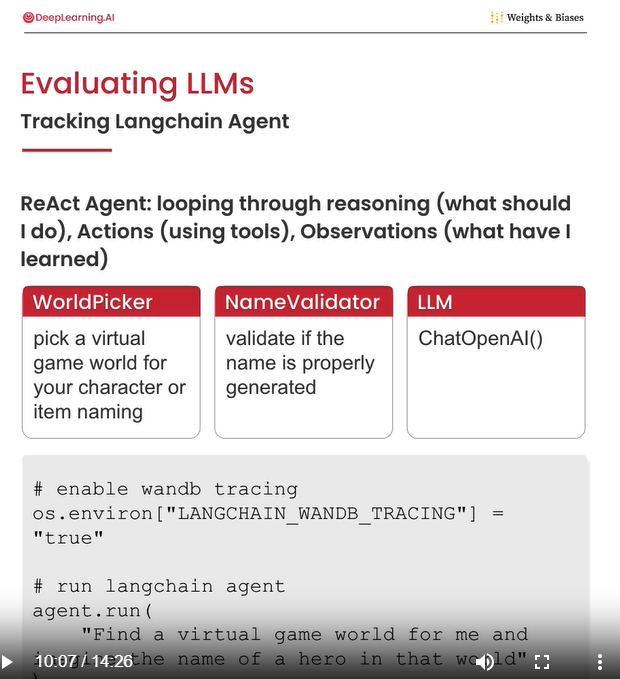

In [8]:
# Import things that are needed generically
from langchain.agents import AgentType, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool

from typing import Optional

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)

In [ ]:
wandb.init(project=PROJECT, job_type="generation")

In [ ]:
os.environ["LANGCHAIN_WANDB_TRACING"] = "true"

In [ ]:
class WorldPickerTool(BaseTool):
    name = "pick_world"
    description = "pick a virtual game world for your character or item naming"
    worlds = [
                "a mystic medieval island inhabited by intelligent and funny frogs",
                "a modern anthill featuring a cyber-ant queen and her cyber-ant-workers",
                "a digital world inhabited by friendly machine learning engineers"
            ]

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool."""
        time.sleep(1)
        return random.choice(self.worlds)

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("pick_world does not support async")
        
class NameValidatorTool(BaseTool):
    name = "validate_name"
    description = "validate if the name is properly generated"

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool."""
        time.sleep(1)
        if len(query) < 20:
            return f"This is a correct name: {query}"
        else:
            return f"This name is too long. It should be shorter than 20 characters."

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("validate_name does not support async")

In [ ]:
llm = ChatOpenAI(temperature=0.7)

In [ ]:
tools = [WorldPickerTool(), NameValidatorTool()]
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=True
)

In [ ]:
agent.run("Find a virtual game world for me and imagine the name of a hero in that world")

In [ ]:
agent.run("Find a virtual game world for me and imagine the name of a jewel in that world")

In [ ]:
agent.run("Find a virtual game world for me and imagine the name of food in that world.")

In [ ]:
wandb.finish()